# TECS ML rotation:
# What causes a molecule to be toxic and how can we predict it?


The “Toxicology in the 21st Century” (Tox21) initiative created a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge. This dataset contains qualitative toxicity measurements for 8k compounds on 12 different targets, including nuclear receptors and stress response pathways.

Random splitting is recommended for this dataset.

The raw data csv file contains columns below:

“smiles” - SMILES representation of the molecular structure

“NR-XXX” - Nuclear receptor signaling bioassays results

“SR-XXX” - Stress response bioassays results

please refer to https://tripod.nih.gov/tox21/challenge/data.jsp for details.

This problem is a classification problem: Toxic/Non-toxic.

References:
1. https://moleculenet.org/ website and paper on the datasets
2. https://deepchem.readthedocs.io/en/latest/index.html manual
3. https://github.com/deepchem/deepchem/tree/master/examples/tutorials tutorials


In [2]:
# lets load our libraries


import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings


# Loading the dataset example

In [3]:
# this line loads the  dataset - we are using the extended connectivity fingerprints here,
# there are several featurizers for you to try
# the splitter splits the dataset for you, refer to the MoleculeNet paper to see which one you need
tasks, datasets, transformers = dc.molnet.load_tox21(
    featurizer='GraphConv',
    splitter='random')

print(datasets)
# the datasets object is already split into the train, validation and test dataset
train_dataset, valid_dataset, test_dataset = datasets
## N.B. Some molecules may not featurize and you'll get a warning this is OK

(<DiskDataset X.shape: (6264,), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (783,), y.shape: (783, 12), w.shape: (783, 12), ids: ['CCCCCCCCCCCCCCCCCC(=O)O[AlH3](O)O' 'Nc1ccc(Br)cc1'
 'CC(C)(CCC(=O)O)C(=O)O' ... 'O=C1OC(=O)C2CC=CCC12'
 'CCCC[Sn](CCCC)(OC(C)=O)OC(C)=O' 'CCOC(=O)N(C)N=O'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (784,), y.shape: (784, 12), w.shape: (784, 12), ids: ['CCc1nn(C2CCCCC2)c2cc([C@]3(C#N)CC[C@@H](C(=O)O)CC3)ccc12' 'O=C(O)CBr'
 'CCc1cc(C(N)=S)ccn1' ... 'CC(C)(S)C(=O)N[C@@H](CS)C(=O)O'
 'CC1(C)C(/C=C\\C=C/C=C\\C=C2\\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21'
 'C[C@]12CCC(=O)C[C@@H]1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@]2(C)O'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>)


In [39]:
train_dataset.get_shape

<bound method DiskDataset.get_shape of <DiskDataset X.shape: (6264,), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>>

In [40]:
# Dataset contains the input fingerprints as X, the output toxicity is stored in y, and the IDS are the smiles strings
print(test_dataset)


<DiskDataset X.shape: (784,), y.shape: (784, 12), w.shape: (784, 12), ids: ['CCc1nn(C2CCCCC2)c2cc([C@]3(C#N)CC[C@@H](C(=O)O)CC3)ccc12' 'O=C(O)CBr'
 'CCc1cc(C(N)=S)ccn1' ... 'CC(C)(S)C(=O)N[C@@H](CS)C(=O)O'
 'CC1(C)C(/C=C\\C=C/C=C\\C=C2\\N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21'
 'C[C@]12CCC(=O)C[C@@H]1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@]2(C)O'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


In [41]:
test_dataset.w

array([[1.0443765720445561, 1.0360893641397746, 1.1347732181425485, ...,
        1.0605688561489666, 0.0, 15.903225806451612],
       [1.0443765720445561, 1.0360893641397746, 1.1347732181425485, ...,
        1.0605688561489666, 1.1919917864476386, 1.067099567099567],
       [1.0443765720445561, 1.0360893641397746, 1.1347732181425485, ...,
        1.0605688561489666, 1.1919917864476386, 1.067099567099567],
       ...,
       [1.0443765720445561, 1.0360893641397746, 1.1347732181425485, ...,
        0.0, 1.1919917864476386, 1.067099567099567],
       [1.0443765720445561, 0.0, 0.0, ..., 0.0, 0.0, 1.067099567099567],
       [23.534412955465587, 28.70899470899471, 0.0, ..., 0.0, 0.0,
        1.067099567099567]], dtype=object)

In [10]:
# number of epochs, you will likely need more than this
nb_epoch = 50
# load a simple graph convolutional neural network
model = dc.models.GraphConvModel(n_tasks=12, mode='classification', dropout=0.2)
# fit the model on the training dataset
model.fit(train_dataset, nb_epoch=nb_epoch)
# get and print the metrics
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

c:\ProgramData\Anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


training set score: {'roc_auc_score': 0.9044313943314769}
test set score: {'roc_auc_score': 0.8030651737706336}


In [11]:
# this line tells deepchem what metric to use to score the datasets
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# model.evaluate() tests the model.
# we have to give it the data to use, the metric (or set of metrics) and the transformer used
print('Over all tasks:')
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Valid set score:", model.evaluate(valid_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))
ground_truth = test_dataset.y
predictions = model.predict(test_dataset)
metric = dc.metrics.roc_auc_score
print('Per task:')
print('Task\t\tROC AUC')
for i in range(len(test_dataset.tasks)):
    score = metric(dc.metrics.to_one_hot(ground_truth[:,i]), predictions[:,i])
    print('{:}\t\t{:.3}'.format(tasks[i],score))

Over all tasks:
Training set score: {'roc_auc_score': 0.9044313943314769}
Valid set score: {'roc_auc_score': 0.8061075157491433}
Test set score: {'roc_auc_score': 0.8030651737706336}
Per task:
Task		ROC AUC
NR-AR		0.761
NR-AR-LBD		0.902
NR-AhR		0.867
NR-Aromatase		0.809
NR-ER		0.694
NR-ER-LBD		0.709
NR-PPAR-gamma		0.887
SR-ARE		0.724
SR-ATAD5		0.865
SR-HSE		0.779
SR-MMP		0.828
SR-p53		0.81


0.0

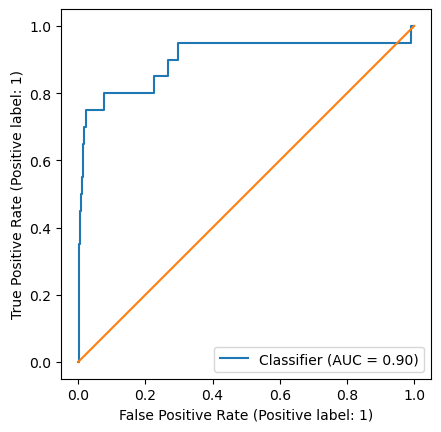

In [12]:
task_number = 1

metrics.RocCurveDisplay.from_predictions(ground_truth[:,task_number], predictions[:,task_number][:,1])
plt.plot([0,1], [0,1])
plt.axis('square')

f1_score(ground_truth[:,task_number], [int(x) for x in predictions[:,task_number][:,1]], average='binary')

In [13]:
test_dataset.y[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Using RDKit

RDkit is a chemistry package that allows you to create chemical features or do very simple computational chemistry.

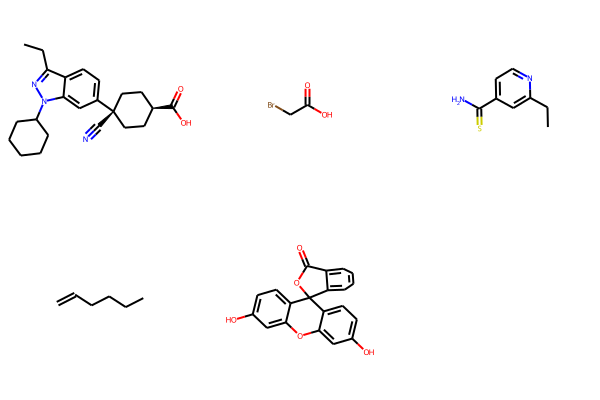

In [63]:
# and this draws a nice image of the first 12 molecules of the test_dataset
SMILES_strings = test_dataset.ids[:5]
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings]
Draw.MolsToGridImage(ms)

RDKit does not give us just a picture of the molecule, it creates a molecule object:

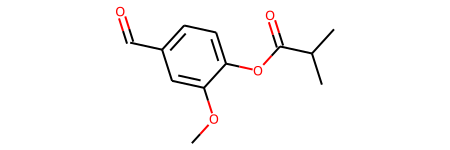

In [19]:
molecule_number = 20
formula = SMILES_strings[molecule_number]
a_molecule = Chem.MolFromSmiles(formula)
a_molecule

The function `dir()` gives a list of the possible things that object can do. (Ignore those that start with ``__`` these are internal functions that you want to leave alone). For example, you could run `a_molecule.GetNumAtoms` to get the number of atoms. More details of what you can calculated with RDKit is here:
https://rdkit.org/docs/index.html

In [20]:
dir(a_molecule)

['AddConformer',
 'ClearComputedProps',
 'ClearProp',
 'Debug',
 'GetAromaticAtoms',
 'GetAtomWithIdx',
 'GetAtoms',
 'GetAtomsMatchingQuery',
 'GetBondBetweenAtoms',
 'GetBondWithIdx',
 'GetBonds',
 'GetBoolProp',
 'GetConformer',
 'GetConformers',
 'GetDoubleProp',
 'GetIntProp',
 'GetNumAtoms',
 'GetNumBonds',
 'GetNumConformers',
 'GetNumHeavyAtoms',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetRingInfo',
 'GetStereoGroups',
 'GetSubstructMatch',
 'GetSubstructMatches',
 'GetUnsignedProp',
 'HasProp',
 'HasSubstructMatch',
 'NeedsUpdatePropertyCache',
 'RemoveAllConformers',
 'RemoveConformer',
 'SetBoolProp',
 'SetDoubleProp',
 'SetIntProp',
 'SetProp',
 'SetUnsignedProp',
 'ToBinary',
 'UpdatePropertyCache',
 '__DebugMol',
 '__GetSubstructMatch',
 '__GetSubstructMatches',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getinitargs__',
 '__gt__',
 '__hash__',
 '__

In [21]:
a_molecule.GetNumAtoms()

16

# More about the dataset
The input, `X`, is a fingerprint, a list of `1`s and `0`s for wether a feature is present or not (a feature like a functional group). There are other types of input that you get from other featurizers that are needed for different ML models.

The output `y` is the is molecule's toxicity against various targets.

If there are `1.`s below indicate that this model failed a toxicity test! I.e. it was toxic against that receptor.

In [22]:
test_dataset.y[molecule_number]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

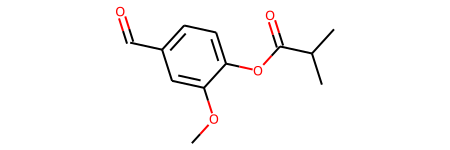

In [23]:
# the molecule again.
a_molecule

These are the tasks:

In [24]:
test_dataset.tasks

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

#### How many toxic molecules do we have?

 You can investigate the data, for example, below is the count of toxic drug candiates

In [25]:
# you will probably want to do this for all the datasets
# but lets just look at the test dataset here
# this is the number of toxic molecules for each task
sum(test_dataset.y)

array([31., 20., 70., 29., 83., 27., 27., 88., 28., 31., 78., 35.])

In [26]:
#This is how many molecules there are in this dataset
len(test_dataset)

784

Text(0.5, 1.0, 'Test Dataset')

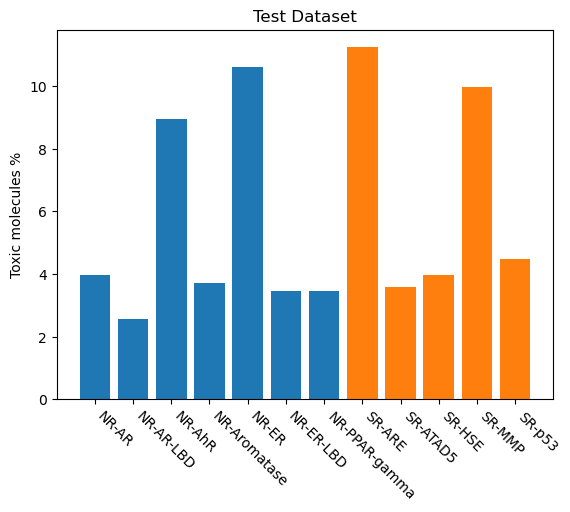

In [14]:
# Here we plot the percentages of toxic molecules per task
ax=plt.bar(test_dataset.tasks[:7],100*sum(test_dataset.y[:,:7])/len(test_dataset))
plt.bar(test_dataset.tasks[7:],100*sum(test_dataset.y[:,7:])/len(test_dataset))
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Toxic molecules %")
#plt.xlabel("Tzxcasks")
plt.title("Test Dataset")

### THIS IS A SMALL NUMBER OF TOXIC MOLECULES!

This is a very unbalanced dataset, you only have around 5-10% toxic molecules and the rest are non-toxic, this is an unbalanced dataset.

In [28]:
# the nuclear reactor tasks
test_dataset.tasks[:7]

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma']

In [29]:
# the stress receptor tasks
test_dataset.tasks[7:]

['SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

In [4]:
tox_df = train_dataset.to_dataframe()

tox_df = tox_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]
tox_df['tox'] = tox_df.sum(axis=1)

tox_df['tox_bin'] = np.where(tox_df['tox'] > 0, 1, 0)

tox_df


,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
6259,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1
6260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
print(sum(tox_df['tox_bin']))

print(len(tox_df))


1534
6264


In [5]:
test_tox_df = test_dataset.to_dataframe()
test_tox_df = test_tox_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]
test_tox_df['tox'] = test_tox_df.sum(axis=1)
test_tox_df['tox_bin'] = np.where(test_tox_df['tox'] > 0, 1, 0)

test_tox_df

,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
valid_tox_df = valid_dataset.to_dataframe()
valid_tox_df = valid_tox_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]
valid_tox_df['tox'] = valid_tox_df.sum(axis=1)
valid_tox_df['tox_bin'] = np.where(valid_tox_df['tox'] > 0, 1, 0)

test_tox_df

,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# This makes new datasets that only include the NR tasks
NR_train_dataset = dc.data.DiskDataset.from_numpy(
    train_dataset.X, # take all of X
    tox_df.iloc[:,-1:], # take only the first 7 answers
    w=np.ones((len(train_dataset), 1)),
    ids=train_dataset.ids, # all ids
    tasks=['toxicity']) # and only the first 7 task labels

NR_valid_dataset = dc.data.DiskDataset.from_numpy(
    valid_dataset.X,
    valid_tox_df.iloc[:,-1:],
    w=np.ones((len(valid_dataset), 1)),
    ids=valid_dataset.ids,
    tasks=['toxicity'])

NR_test_dataset = dc.data.DiskDataset.from_numpy(
    test_dataset.X,
    test_tox_df.iloc[:,-1:],
    w=np.ones((len(test_dataset), 1)),
    ids=test_dataset.ids,
    tasks=['toxicity'])

# This transforms the dataset to try to deal with the unbalanced classes
#transformer = dc.trans.BalancingTransformer(dataset=NR_train_dataset)
#NR_train_dataset_trans = transformer.transform(NR_train_dataset)

#transformer = dc.trans.BalancingTransformer(dataset=NR_valid_dataset)
#NR_valid_dataset_trans = transformer.transform(NR_valid_dataset)

#transformer = dc.trans.BalancingTransformer(dataset=NR_test_dataset)
#NR_test_dataset_trans = transformer.transform(NR_test_dataset)

In [161]:
print(NR_train_dataset.w.shape)
print(NR_test_dataset.w.shape)
print(NR_test_dataset.y.shape)

(6264, 1)
(784, 1)
(6264, 1)


In [156]:
type(train_dataset)

deepchem.data.datasets.DiskDataset

In [157]:
NR_train_dataset

<DiskDataset X.shape: (6264,), y.shape: (6264, 1), w.shape: (6264, 1), task_names: ['toxicity']>

In [158]:
NR_train_dataset.tasks

['toxicity']

Text(0.5, 1.0, 'Test Dataset')

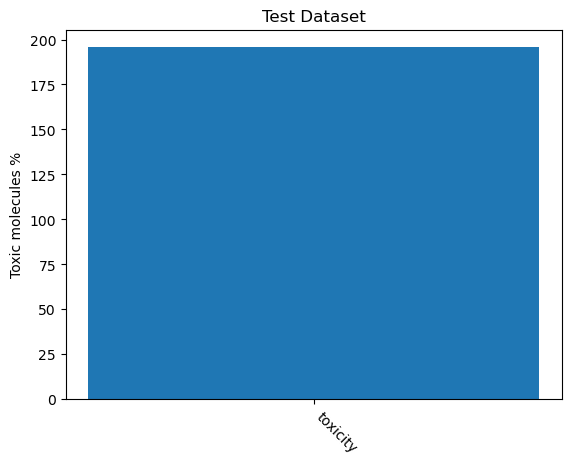

In [159]:
# Here we plot the percentages of toxic molecules per task
ax=plt.bar(NR_test_dataset.tasks[:7],100*sum(NR_test_dataset.y[:,:7])/len(NR_test_dataset))
plt.bar(NR_test_dataset.tasks[7:],100*sum(NR_test_dataset.y[:,7:])/len(NR_test_dataset))
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Toxic molecules %")
#plt.xlabel("Tzxcasks")
plt.title("Test Dataset")

# Machine learning example
(see also the 4th and 5th notebooks in the Machine Learning for Chemist's course).
The code below uses one of `deepchem`'s models. There are also relevant models in the `sklearn` module. There are more options that be tuned. The process of changing these options is called *hyperparameter optimisation*.

Here we train a classifier that will work on more than one task at a time. Classifiers put molecules into two classes: toxic or not toxic and multiclass classifiers do it on a per assay basis.

Here we train a MultitaskClassifier on the NR datasets

In [198]:
nb_epoch = 100


model=dc.models.GraphConvModel(
    n_tasks=1,
    dropouts=0.5)

model.fit(NR_train_dataset, nb_epoch=nb_epoch)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)


c:\ProgramData\Anaconda3\envs\ml-for-chemists-tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [199]:
print('training set score:', model.evaluate(NR_train_dataset, [metric]))
print('test set score:', model.evaluate(NR_test_dataset, [metric]))

training set score: {'roc_auc_score': 0.9976580179772927}
test set score: {'roc_auc_score': 0.7347372774367681}


This tests the trained model. Classifiers are usually tested by looking at the Area Under the Curve of the Receiver Operator Curve or **ROC AUC**, these are the numbers in deepchem that you will compare to. ROC AUC goes from 0 to 1, 0.5 means it's as good as random guessing, 1 is perfect, and anything less than 0.5 means it's worse than guessing.

In [200]:
# this line tells deepchem what metric to use to score the datasets
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

# model.evaluate() tests the model.
# we have to give it the data to use, the metric (or set of metrics) and the transformer used
print('Over all tasks:')
print("Training set score:", model.evaluate(NR_train_dataset, [metric], transformers))
print("Valid set score:", model.evaluate(NR_valid_dataset, [metric], transformers))
print("Test set score:", model.evaluate(NR_test_dataset, [metric], transformers))
ground_truth = NR_test_dataset.y
predictions = model.predict(NR_test_dataset)
metric = dc.metrics.roc_auc_score
print('Per task:')
print('Task\t\tROC AUC')
for i in range(len(NR_test_dataset.tasks)):
    score = metric(dc.metrics.to_one_hot(ground_truth[:,i]), predictions[:,i])
    print('{:}\t\t{:.3}'.format(tasks[i],score))

Over all tasks:
Training set score: {'roc_auc_score': 0.9976580179772927}
Valid set score: {'roc_auc_score': 0.723224043715847}
Test set score: {'roc_auc_score': 0.7347372774367681}
Per task:
Task		ROC AUC
NR-AR		0.735


Here is a ROC AUC for one of the tasks. It looks OK.

[[[7.7162810e-02 9.2283714e-01]]

 [[9.9999988e-01 1.3786203e-07]]

 [[9.9986851e-01 1.3148940e-04]]

 ...

 [[1.0000000e+00 4.4170896e-08]]

 [[9.9803632e-01 1.9636275e-03]]

 [[5.4887671e-02 9.4511229e-01]]]
[[7.7162810e-02 9.2283714e-01]
 [9.9999988e-01 1.3786203e-07]
 [9.9986851e-01 1.3148940e-04]
 ...
 [1.0000000e+00 4.4170896e-08]
 [9.9803632e-01 1.9636275e-03]
 [5.4887671e-02 9.4511229e-01]]


Text(0.5, 1.0, 'toxicity')

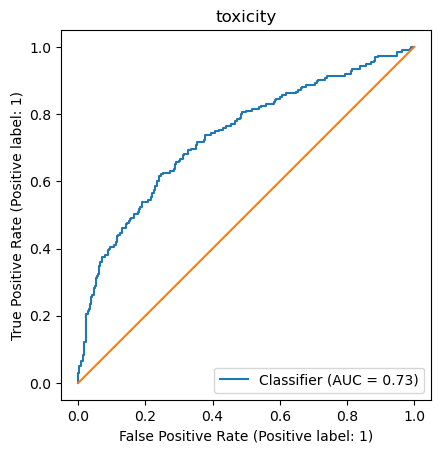

In [201]:
print(predictions)
print(predictions[:,0])

metrics.RocCurveDisplay.from_predictions(ground_truth, predictions[:,0][:,1])
plt.plot([0,1], [0,1])
plt.axis('square')
plt.title(NR_test_dataset.tasks[0])

But, in this feild you can score the accuracy of your model in several ways, the metric you use for classificiation where you have unbalanced datasets is the F1 score (there are also other valid choices). And the f1 score for this task is terrible! (F1 goes between 0 and 1)

In [202]:

f1_score(
    ground_truth,
    [int(x) for x in predictions[:,0][:,1]],
    average='binary')

0.0

This code counts how many molecules were predicted to be toxic:

In [21]:
sum([int(x) for x in predictions[:,task_number][:,1]])

0

This model has solved the problem by just saying everything is non-toxic, this is not what we want!

Here's the results for another task

0.0

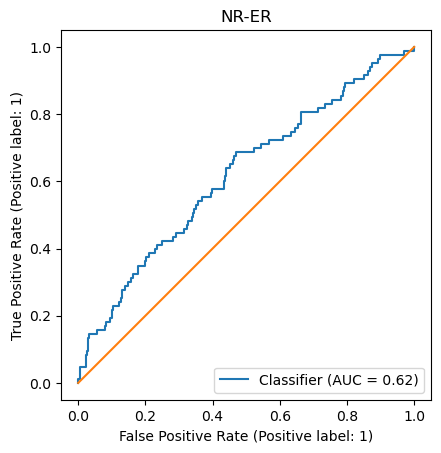

In [22]:
task_number = 4
metrics.RocCurveDisplay.from_predictions(ground_truth[:,task_number], predictions[:,task_number][:,1])
plt.plot([0,1], [0,1])
plt.axis('square')
plt.title(NR_test_dataset.tasks[task_number])
f1_score(ground_truth[:,task_number], [int(x) for x in predictions[:,task_number][:,1]], average='binary')

# Training models

This approach (GC + multiclass classifier) isn't very good, it's gotten nice AUC ROC curves but this is misleading. You will have to have a look at how to train with unbalanced classes.

See for example:
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/
and the balancing and unbalancing transformers
https://deepchem.readthedocs.io/en/latest/api_reference/transformers.html?highlight=dc.trans.BalancingTransformer#deepchem.trans.BalancingTransformer

Now go and have a play

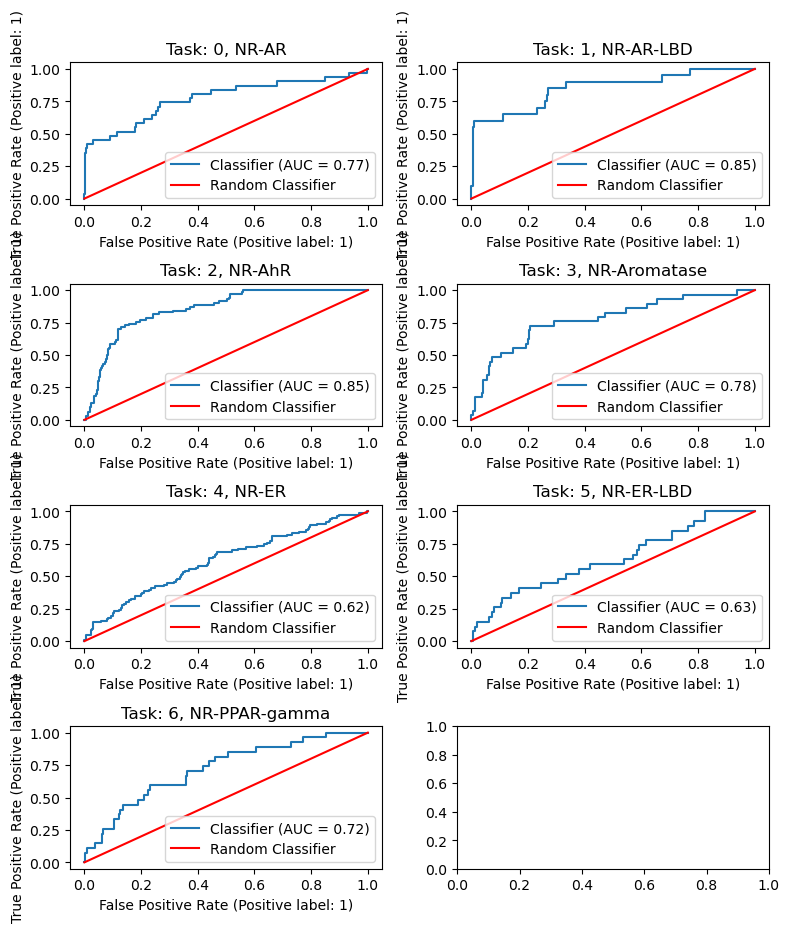

In [23]:

def plot_roc_curves(clf):
  fig, axes = plt.subplots(4,2, figsize=(8,9))

  ground_truth = NR_test_dataset.y
  predictions = clf.predict(NR_test_dataset)

  for i in range(7):
    task_number = i
    plt.sca(axes[i // 2, i % 2])
    metrics.RocCurveDisplay.from_predictions(ground_truth[:,task_number], predictions[:,task_number][:,1], ax=axes[i // 2, i % 2])
    plt.plot([0,1], [0,1], 'r-', label='Random Classifier')
    plt.legend()
    plt.title(f'Task: {i}, {test_dataset.tasks[i]}')

  fig.tight_layout()



plot_roc_curves(model)

In [8]:
from rdkit.Chem import Fragments
from rdkit.Chem import Descriptors

train_dataset, valid_dataset, test_dataset = datasets

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)


SMILES_strings = test_dataset.ids

mol = [Chem.MolFromSmiles(formula) for formula in SMILES_strings]

def toxic_functional_groups(formula):
    total = 0
    total += Chem.Fragments.fr_ArN(formula)
    total += Chem.Fragments.fr_Al_COO(formula)
    total += Chem.Fragments.fr_Ar_COO(formula)
    total += Chem.Fragments.fr_Ar_OH(formula)
    total += Chem.Fragments.fr_nitro_arom(formula)
    total += Chem.Fragments.fr_C_S(formula)
    total += Chem.Fragments.fr_epoxide(formula)



    return total

def total_halogens(formula):
    return Chem.Fragments.fr_halogen(formula)

def total_heaviest_atoms(formula):
    count = 0
    for atom in formula.GetAtoms():
        if atom.GetAtomicNum() > 10:
            count += 1
    
    return count

    

mol_wts = [Chem.rdMolDescriptors.CalcExactMolWt(formula) for formula in mol]
log_p = [Chem.rdMolDescriptors.CalcCrippenDescriptors(formula)[0] for formula in mol]
h_bond_acceptors = [Chem.rdMolDescriptors.CalcNumHBA(formula) for formula in mol]
h_bond_donors = [Chem.rdMolDescriptors.CalcNumHBD(formula) for formula in mol]
rot_bond = [Chem.rdMolDescriptors.CalcNumRotatableBonds(formula) for formula in mol]
toxic_grp = [toxic_functional_groups(formula) for formula in mol]
total_hal = [total_halogens(formula) for formula in mol]
heaviest_at = [total_heaviest_atoms(formula) for formula in mol]



dataframe = pd.DataFrame(data={'SMILES':SMILES_strings, 
                               'mol_wts': mol_wts, 
                               'log_p': log_p, 
                               'h_bond_acceptors': h_bond_acceptors, 
                               'h_bond_donors':h_bond_donors, 
                               'rot_bond':rot_bond, 
                               'toxic_grp':toxic_grp,
                               'total_hal':total_hal,
                               'total_heaviest_atoms':heaviest_at,
                               'tox': test_tox_df['tox_bin']
                               })

dataframe


,SMILES,mol_wts,log_p,h_bond_acceptors,h_bond_donors,rot_bond,toxic_grp,total_hal,total_heaviest_atoms,tox
0,CCc1nn(C2CCCCC2)c2cc([C@]3(C#N)CC[C@@H](C(=O)O...,379.225977,5.14008,4,1,4,1,0,0,1
1,O=C(O)CBr,137.931641,0.46590,1,1,1,1,1,1,0
2,CCc1cc(C(N)=S)ccn1,166.056469,1.27820,2,1,2,1,0,1,1
3,C=CCCCC,84.093900,2.36260,0,0,3,0,0,0,0
4,O=C1OC2(c3ccc(O)cc3Oc3cc(O)ccc32)c2ccccc21,332.068473,3.66580,5,2,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
779,NC(=O)c1ccccc1,121.052764,0.78550,1,1,1,0,0,0,0
780,Cc1ccc(S)cc1,124.034671,2.28372,1,1,0,0,0,1,0
781,CC(C)(S)C(=O)N[C@@H](CS)C(=O)O,223.033685,0.19400,4,4,4,1,0,2,0
782,CC1(C)C(/C=C\C=C/C=C\C=C2\N(CCCCS(=O)(=O)[O-])...,751.288103,8.37030,7,0,14,0,0,2,0


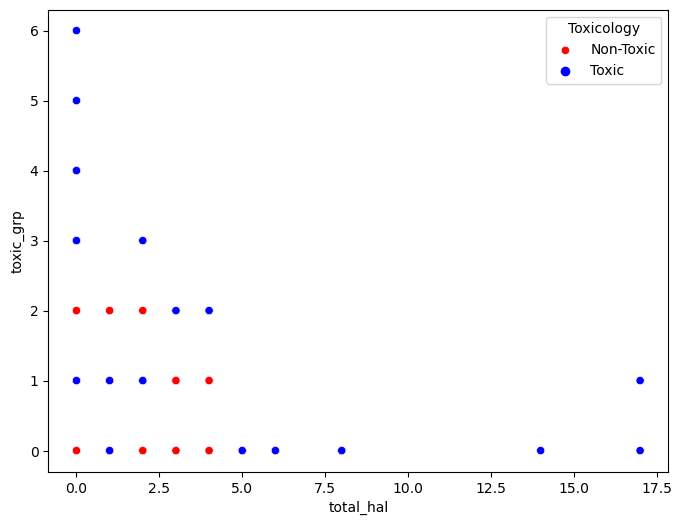

In [13]:
from matplotlib import colors
import seaborn as sns


plt.figure(figsize=(8,6))

sns.scatterplot(x='total_hal', y='toxic_grp', hue='tox', data=dataframe, palette={0: 'blue', 1:'red'}, legend=True)

plt.legend(title='Toxicology', labels=['Non-Toxic', 'Toxic'])

